# Transformer

###### Attention 개입 도입해 어떤 특정 시점에 집중
###### positional encoding을 사용해 sequential한 위치 정보 보존
###### 이후 시점에 대한 masking을 적용해 이전 시점의 값만 이후에 영향 미치도록 제한
###### 모든 과정을 병렬처리 가능하도록 구현

##### Transformer는 input sentence를 넣어 output sentence 생성

###### 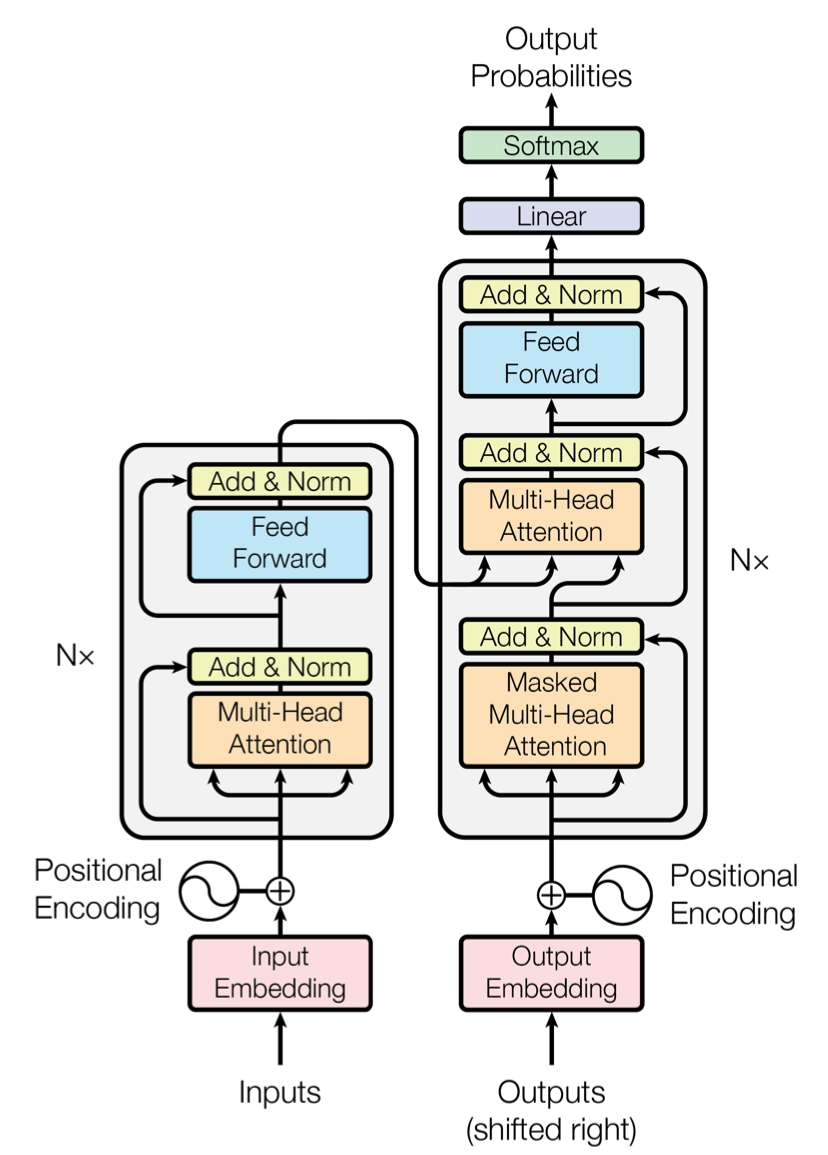

#### Transformer's Input(positional Encoding)
    Transformer의 input으로 들어오는 문장의 shape (n_batch x seq_len)
    Encoder와 Decoder의 input : n_batch x seq_len x d_embed

###### Transformer source/target sentence에 대한 각각의 Embedding 포함
    1) Token embedding
    2) positional embedding

In [21]:
class TransformerEmbedding(nn.Module):

    def __init__(self, token_embed, pos_embed):
        super(TransformerEmbedding, self).__init__()
        self.embedding = nn.Sequential(token_embed, pos_embed)


    def forward(self, x):
        out = self.embedding(x)
        return out

In [23]:
class TokenEmbedding(nn.Module):

    def __init__(self, d_embed, vocab_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_embed)
        self.d_embed = d_embed


    def forward(self, x):
        out = self.embedding(x) * math.sqrt(self.d_embed)
        return out

In [22]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_embed, max_len=256, device=torch.device("cpu")):
        super(PositionalEncoding, self).__init__()
        encoding = torch.zeros(max_len, d_embed)
        encoding.requires_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2) * -(math.log(10000.0) / d_embed))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = encoding.unsqueeze(0).to(device)


    def forward(self, x):
        _, seq_len, _ = x.size()
        pos_embed = self.encoding[:, :seq_len, :]
        out = x + pos_embed
        return out

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [25]:
class Transformer(nn.Module):

    def __init__(self, src_embed, tgt_embed, encoder, decoder):
        super(Transformer, self).__init__()
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator


    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)


    def decode(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        return self.decoder(self.tgt_embed(tgt), encoder_out, tgt_mask, src_tgt_mask)


    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        src_tgt_mask = self.make_src_tgt_mask(src, tgt)
        encoder_out = self.encode(src, src_mask)
        decoder_out = self.decode(tgt, encoder_out, tgt_mask, src_tgt_mask)
        out = self.generator(decoder_out)
        out = F.log_softmax(out, dim=-1)
        return out, decoder_out

##### Transformer Encoder
    sentence를 input으로 받아 하나의 vector를 생성하는 함수
    Encoding으로 생성된 vector = context (문맥 함축해 담은 vector)
    

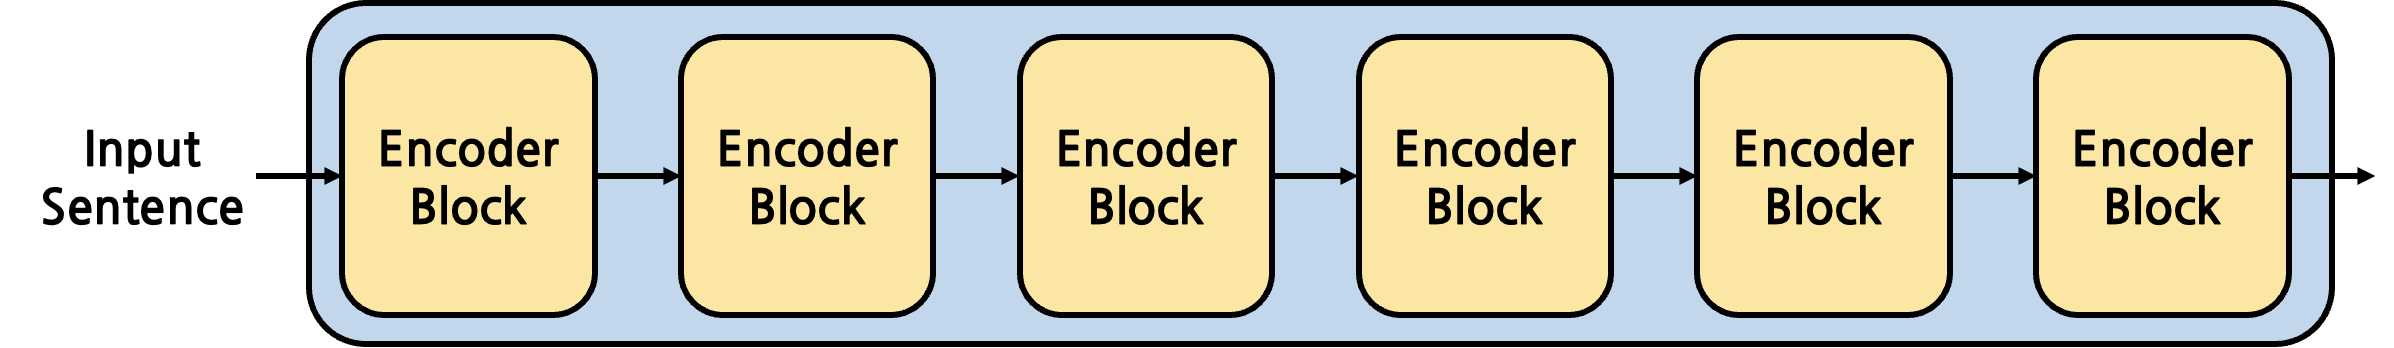

    - Encoder는 Encoder Block이 N개 쌓여진 형태 (논문에선 N = 6)
    - Encoder Block의 input과 output의 형태는 동일한 shape을 갖는 matrix
    - Encoder Block은 input으로 들어오는 vector에 대해 더 높은 차원에서의 context(더 추상적인 정보)를 담음
    
    
##### Transformer Decoder
    sentence, context를 input으로 받아 sentence를 output으로 생성
    

In [4]:
class Encoder(nn.Module):

    def __init__(self, encoder_block, n_layer):  # n_layer: Encoder Block의 개수
        super(Encoder, self).__init__()
        self.layers = []
        for i in range(n_layer):
            self.layers.append(copy.deepcopy(encoder_block))


    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

##### Encoder Block
    
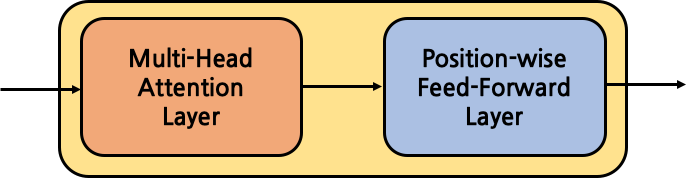

In [13]:
class EncoderBlock(nn.Module):

    def __init__(self, self_attention, position_ff):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention
        self.position_ff = position_ff
        self.residuals = [ResidualConnectionLayer() for _ in range(2)]


    def forward(self, src, src_mask):
        out = src
        out = self.residuals[0](out, lambda out: self.self_attention(query=out, key=out, value=out, mask=src_mask))
        out = self.residuals[1](out, self.position_ff)
        return out

#### What is Attention?
    Multi-Head Attention은 Scaled Dot-product-Attention을 병렬적으로 여러 개 수행
    Self-attention은 같은 문장 내의 두 token 사이의 Attention 계산
    cross-attention은 서로 다른 문장에 각각 존재하는 두 token 사이의 attention 계산
    
###### Attention
    Query : 현재 시점의 token
    Key : attention을 구하고자 하는 대상 token을 의미
    Value : attention을 구하고자 하는 대상 token을 의미 (Key와 동일한 token)
    => Query와 가장 부합하는 Attention이 가장 높은 token find
    => key, value를 문장의 처음부터 끝까지 탐색 시킴
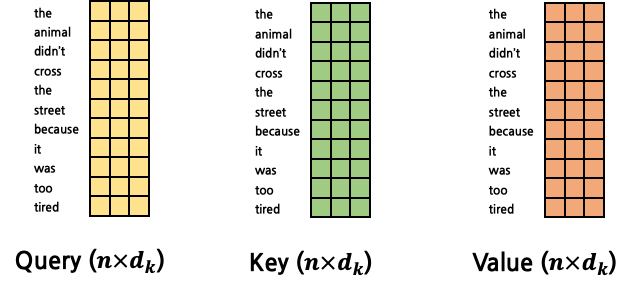
    
    1) input으로 들어오는 token embedding vector를 fully connected layer에 넣어 새 vector 생성
    2) 새 vector 생성하는 FC layer는 모두 다름
    3) self-attention에서는 Q, K, V 구하기 위해 3개의 서로 다른 FC layer 존재
    
    *scaled Dot-product Attention

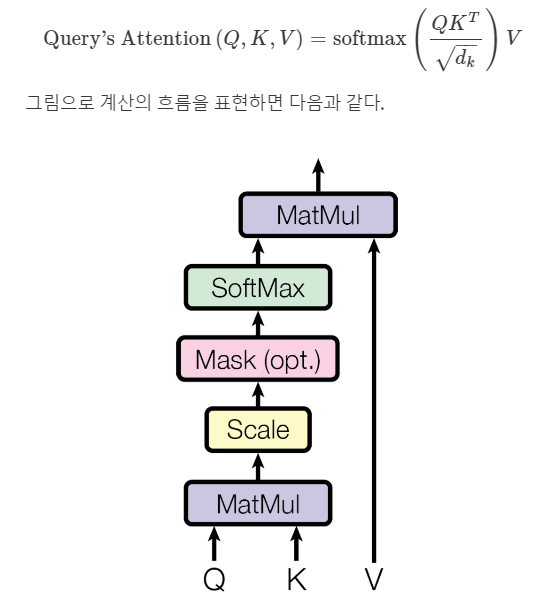

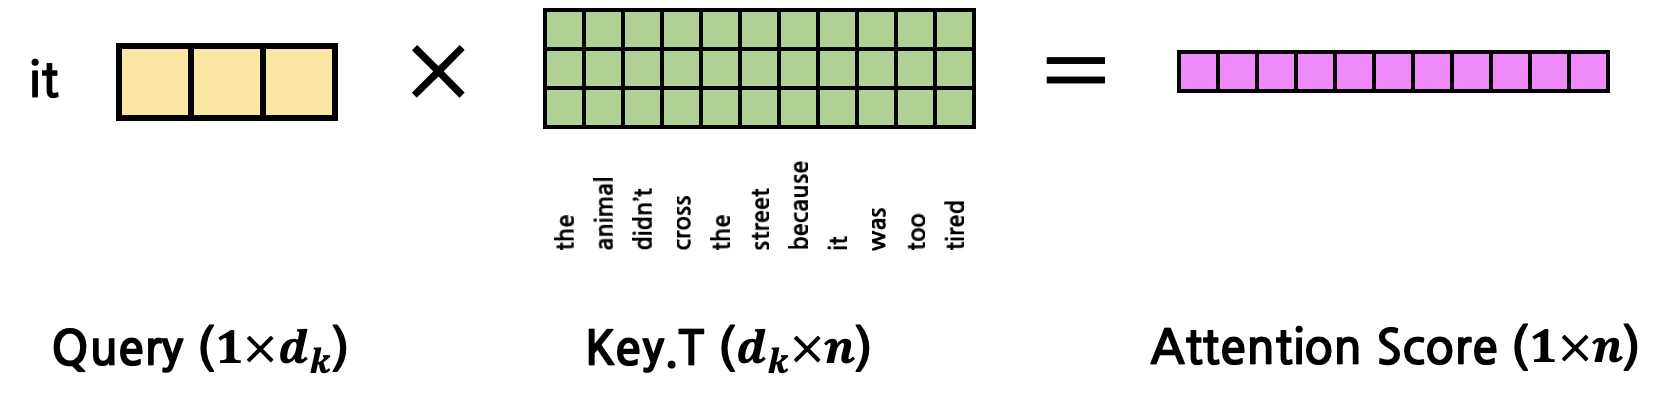
    
    Attention score는 softmax를 사용해 확률값으로 변환하게 됨
    각 Attention score는 모두 더하면 1인 확률값
    => Q의 token과 해당 token이 얼마나 Attention을 갖는지(연관성이 짙은지)에 대한 비율
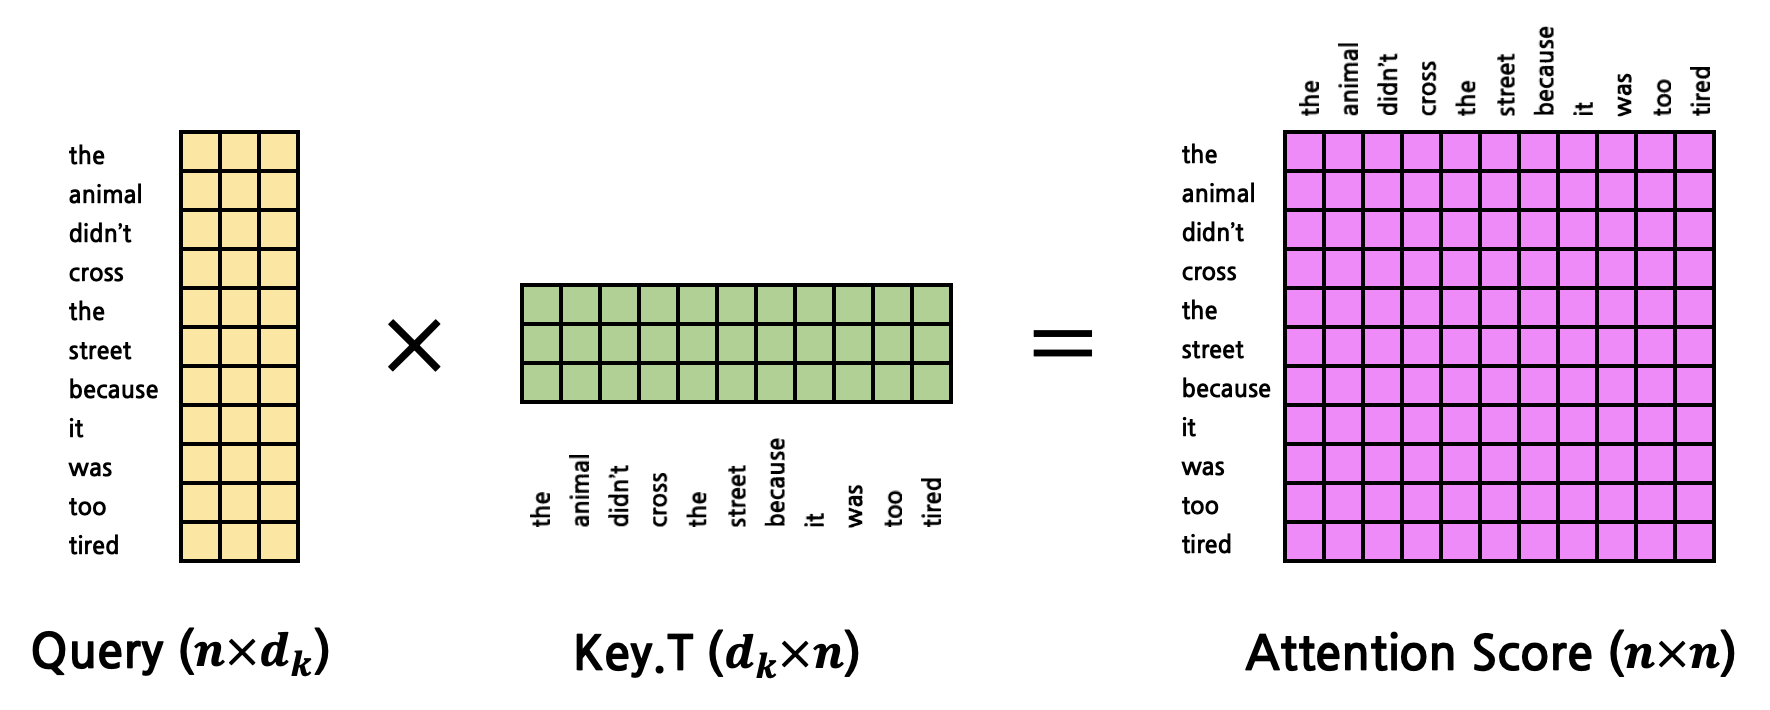
    
    Attention prob (n*n) = Attention score (n*n)
    앞서 구한 비율에 최종적으로 V와 곱해 각 비율만큼만 반영한다는 의미

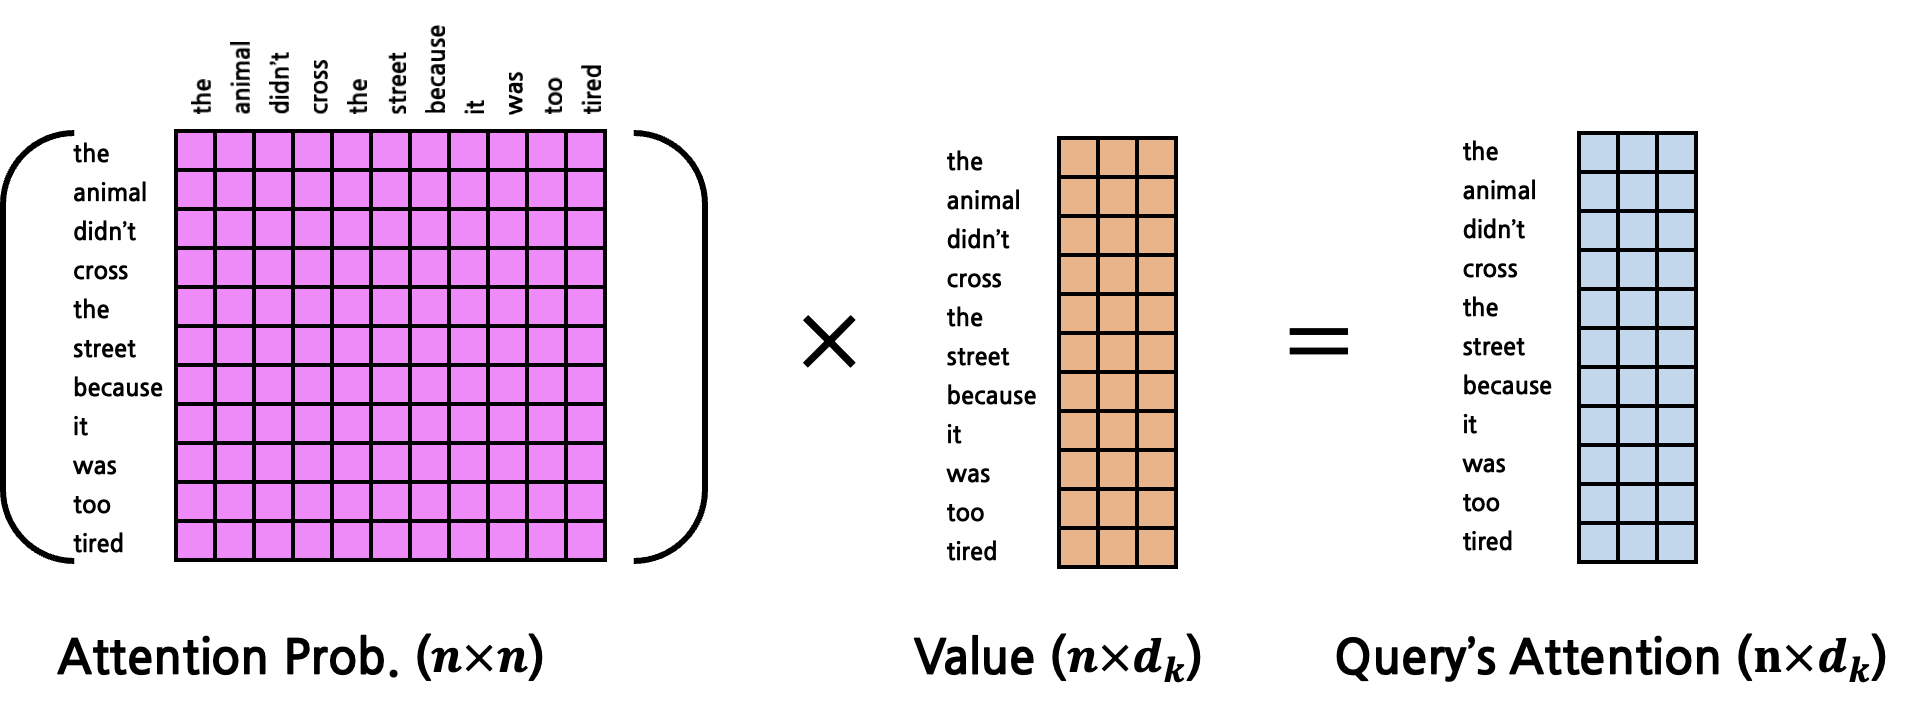

###### Q, K, V를 구하는 FC layer
    FC layer의 input은 word embedding vector
    output은 각각 Q, K, V
    input shape : n(seq_len)*d_embed(word embedding dimension)
    output shape : n(seq_len)*d_k
    각 FC layer는 서로 다른 weight matrix (d_embed*d_k)
    output shape는 동일하지만 Q, K, V의 실제 값들은 모두 다름

In [6]:
def calculate_attention(query, key, value, mask):
    # query, key, value: (n_batch, seq_len, d_k)
    # mask: (n_batch, seq_len, seq_len)
    d_k = key.shape[-1]
    attention_score = torch.matmul(query, key.transpose(-2, -1)) # Q x K^T, (n_batch, seq_len, seq_len)
    attention_score = attention_score / math.sqrt(d_k)
    
    if mask is not None:
        attention_score = attention_score.masked_fill(mask==0, -1e9)
    attention_prob = F.softmax(attention_score, dim=-1) # (n_batch, seq_len, seq_len)
    out = torch.matmul(attention_prob, value) # (n_batch, seq_len, d_k)
    return out

##### Multi-Head Attention Layer
###### 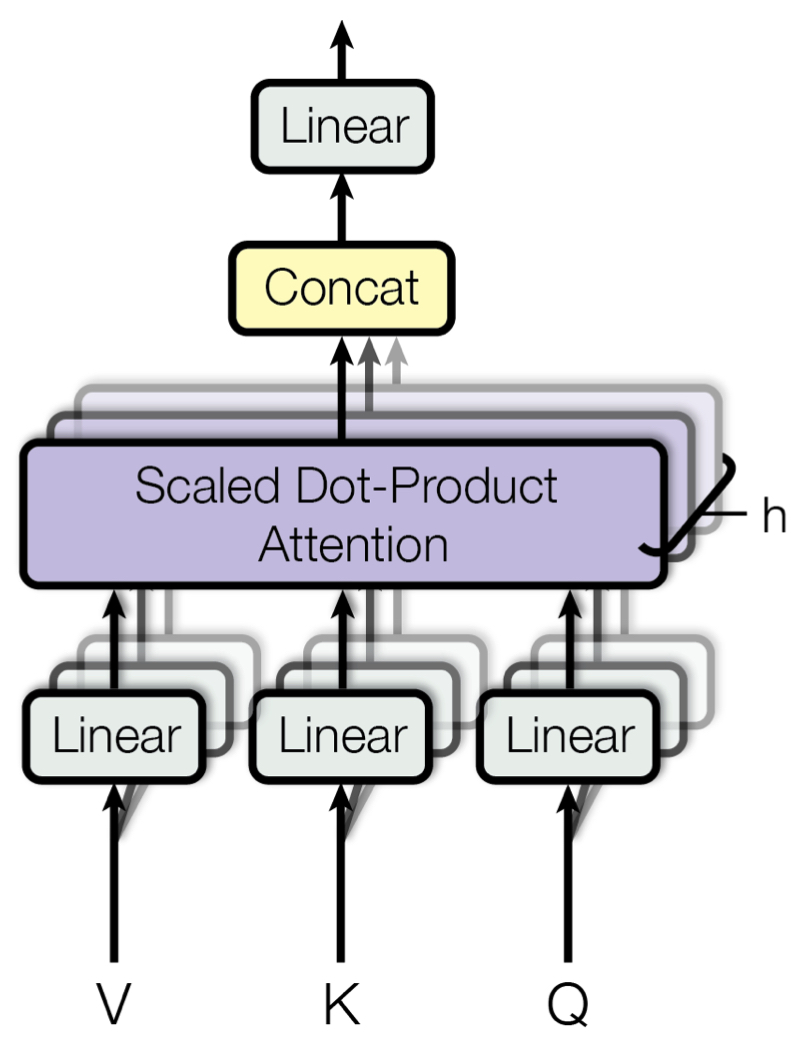

    Scaled Dot Attention을 한 Encoder Layer마다 1회씩 수행하는 것이 아니라 병렬적으로 h회 각각 수행한 뒤, 결과 종합
    논문에서는 h = 8
    FC layer는 3(Q, K, V)*h 개 필요
    

In [7]:
class MultiHeadAttentionLayer(nn.Module):

    def __init__(self, d_model, h, qkv_fc, out_fc):
        super(MultiHeadAttentionLayer, self).__init__()
        self.d_model = d_model
        self.h = h
        self.q_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model)
        self.k_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model)
        self.v_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model)
        self.out_fc = out_fc              # (d_model, d_embed)
    
    def forward(self, *args, query, key, value, mask=None):
        # query, key, value: (n_batch, seq_len, d_embed)
        # mask: (n_batch, seq_len, seq_len)
        # return value: (n_batch, h, seq_len, d_k)
        n_batch = query.size(0)

        # Q, K, V를 구하는 함수
        def transform(x, fc):  # (n_batch, seq_len, d_embed)
            out = fc(x)        # (n_batch, seq_len, d_model)
            out = out.view(n_batch, -1, self.h, self.d_model//self.h) # (n_batch, seq_len, h, d_k)
            out = out.transpose(1, 2) # (n_batch, h, seq_len, d_k)
            return out

        query = transform(query, self.q_fc) # (n_batch, h, seq_len, d_k)
        key = transform(key, self.k_fc)     # (n_batch, h, seq_len, d_k)
        value = transform(value, self.v_fc) # (n_batch, h, seq_len, d_k)

        out = self.calculate_attention(query, key, value, mask) # (n_batch, h, seq_len, d_k)
        out = out.transpose(1, 2) # (n_batch, seq_len, h, d_k)
        out = out.contiguous().view(n_batch, -1, self.d_model) # (n_batch, seq_len, d_model)
        out = self.out_fc(out) # (n_batch, seq_len, d_embed)
        return out

###### forward( )
    Q, K, V는 input sentence embedding (n_batch x seq_len x d_embed)
    3개의 fc layer에 넣어  Q, K, V 구함
    mini-batch 임으로 n_batch x seq_len x seq_len 의 shape
    
###### transformer( )
    Q, K, V를 구하는 함수
    input shape : (n_batch x seq_len x d_embed)
    output shape : (n_batch x seq_len x d_model)
    => d_model을 h와 d_key로 분리
    => shape : n_batch x seq_len x h x d_key
    => transpose해 n_batch x h x seq_len x d_key로 변환
       (calculate_attention의 input 모양)
      

### Pad Mask Code in pytorch
    Q, K => n_batch x seq_len

In [18]:
def make_src_tgt_mask(self, src, tgt):
    pad_mask = self.make_pad_mask(tgt, src)
    return pad_mask

def make_pad_mask(self, query, key, pad_idx=1):
    # query: (n_batch, query_seq_len)
    # key: (n_batch, key_seq_len)
    query_seq_len, key_seq_len = query.size(1), key.size(1)

    key_mask = key.ne(pad_idx).unsqueeze(1).unsqueeze(2)  # (n_batch, 1, 1, key_seq_len)
    key_mask = key_mask.repeat(1, 1, query_seq_len, 1)    # (n_batch, 1, query_seq_len, key_seq_len)

    query_mask = query.ne(pad_idx).unsqueeze(1).unsqueeze(3)  # (n_batch, 1, query_seq_len, 1)
    query_mask = query_mask.repeat(1, 1, 1, key_seq_len)  # (n_batch, 1, query_seq_len, key_seq_len)

    mask = key_mask & query_mask
    mask.requires_grad = False
    return mask

In [10]:
def make_src_mask(self, src):
    pad_mask = self.make_pad_mask(src, src)
    return pad_mask

#### position-wise Feed Forward Layer
    각 FC Layer는 (d_embed×d_ff), (d_ff×d_embed)의 weight matrix를 갖음
    Feed forward layer는 multi-head attention layer의 output을 input으로 넘겨줌

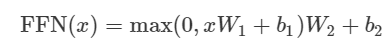
    
    첫번째 FC layer의 output에 RELU()적용
    

In [ ]:
class PositionWiseFeedForwardLayer(nn.Module):

    def __init__(self, fc1, fc2):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.fc1 = fc1   # (d_embed, d_ff)
        self.relu = nn.ReLU()
        self.fc2 = fc2 # (d_ff, d_embed)


    def forward(self, x):
        out = x
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

##### Residual Connection Layer
    y = f(x) => y = f(x)+x
    output을 그대로 사용하지 않고, output에 input을 더한 값 사용
    => 이점) Back propagation 도중 발생하는 gradient vanishing을 방지 가능


In [12]:
class ResidualConnectionLayer(nn.Module):

    def __init__(self):
        super(ResidualConnectionLayer, self).__init__()


    def forward(self, x, sub_layer):
        out = x
        out = sub_layer(out)
        out = out + x
        return out

# Decoder

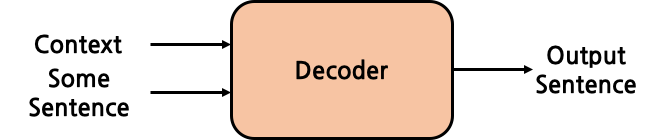

    context와 some sentence를 input으로 받아 output sentence 출력
    context : Encoder의 output
    

In [14]:
# Decoder의 Masking 기법 : subsequent masking
# i번째 token을 생성해낼 때, 1~i-1의 token은 보이지 않도록 처리
#np.tril()을 사용해 lower traiangle 생성

def make_subsequent_mask(query, key):
    # query: (n_batch, query_seq_len)
    # key: (n_batch, key_seq_len)
    query_seq_len, key_seq_len = query.size(1), key.size(1)

    tril = np.tril(np.ones((query_seq_len, key_seq_len)), k=0).astype('uint8') # lower triangle without diagonal
    mask = torch.tensor(tril, dtype=torch.bool, requires_grad=False, device=query.device)
    return mask

In [16]:
#Transformer의 method로 작성

def make_tgt_mask(self, tgt):
    pad_mask = self.make_pad_mask(tgt, tgt)
    seq_mask = self.make_subsequent_mask(tgt, tgt)
    mask = pad_mask & seq_mask
    return pad_mask & seq_mask

#Encoder에서는 사용하는 pad mask(src_mask)만이 forward() 구함
#Decoder에서는 사용한 subsequent + pad_mask(tgt_mask) 구해야 함

### Decoder Block

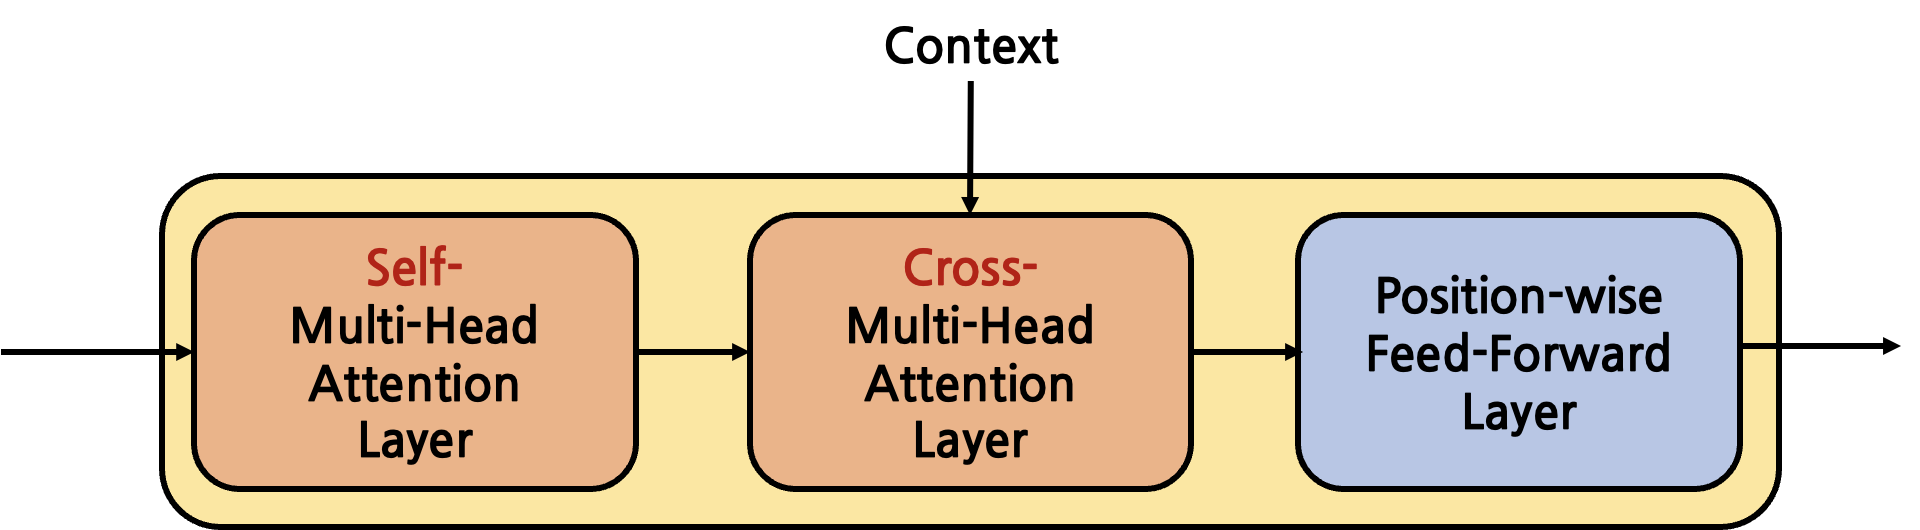

    Decoder Block은 multi-head attention layer가 2개
###### 첫번째 mult-head attention layer 
    self Masked-Multi-Head Attention Layer
    => Decoder의 input으로 주어지는 sentence 내부에서의 attention을 계산
    => 일반적인 pad masking + subsequent masking 적용
    => Ground Truth sentence에 내부에서의 Attention 계산
    
###### 두번째 multi-head attention Layer
    cross-multi-head attention layer
    Decoder Block 내 이전 self-multi-head attention layer에서 넘어온 output을 input으로 받음
    Encoder에서 넘어온 context를 key, value로 사용
    => Decoder에서 넘어온 input에 대한 Attention을 계산
    => Decoder Block 내 이전 layer에서 input이 Query가 됨

In [17]:
class Decoder(nn.Module):

    def __init__(self, decoder_block, n_layer):
        super(Decoder, self).__init__()
        self.n_layer = n_layer
        self.layers = nn.ModuleList([copy.deepcopy(decoder_block) for _ in range(self.n_layer)])


    def forward(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        out = tgt
        for layer in self.layers:
            out = layer(out, encoder_out, tgt_mask, src_tgt_mask)
        return out

In [19]:
class DecoderBlock(nn.Module):

    def __init__(self, self_attention, cross_attention, position_ff):
        super(DecoderBlock, self).__init__()
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.position_ff = position_ff
        self.residuals = [ResidualConnectionLayer() for _ in range(3)]


    def forward(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        out = tgt
        out = self.residuals[0](out, lambda out: self.self_attention(query=out, key=out, value=out, mask=tgt_mask))
        # cross_attention key, value => encoder_out
        #mask : tgt_mask, src_tgt_mask
        out = self.residuals[1](out, lambda out: self.cross_attention(query=out, key=encoder_out, value=encoder_out, mask=src_tgt_mask))
        out = self.residuals[2](out, self.position_ff)
        return out

#### Decoder의 output shape
    n_batch x seq_len x d_embed
    
###### 원하는 output은 target sentence인 n_batch x seq_len
    Generator
    - Decoder output의 마지막 dimension을 d_embed에서 len(vocab)으로 변경
    - 이후 softmax()를 사용해 각 vocabulary에 대한 확률값을 변환 (log_softmax()를 시용해 성능 향상)

In [26]:
def build_model(src_vocab_size, tgt_vocab_size, device=torch.device("cpu"), max_len=256, d_embed=512, n_layer=6, d_model=512, h=8, d_ff=2048):
    import copy
    copy = copy.deepcopy

    src_token_embed = TokenEmbedding(
                                     d_embed = d_embed,
                                     vocab_size = src_vocab_size)
    tgt_token_embed = TokenEmbedding(
                                     d_embed = d_embed,
                                     vocab_size = tgt_vocab_size)
    pos_embed = PositionalEncoding(
                                   d_embed = d_embed,
                                   max_len = max_len,
                                   device = device)

    src_embed = TransformerEmbedding(
                                     token_embed = src_token_embed,
                                     pos_embed = copy(pos_embed))
    tgt_embed = TransformerEmbedding(
                                     token_embed = tgt_token_embed,
                                     pos_embed = copy(pos_embed))

    attention = MultiHeadAttentionLayer(
                                        d_model = d_model,
                                        h = h,
                                        qkv_fc = nn.Linear(d_embed, d_model),
                                        out_fc = nn.Linear(d_model, d_embed))
    position_ff = PositionWiseFeedForwardLayer(
                                               fc1 = nn.Linear(d_embed, d_ff),
                                               fc2 = nn.Linear(d_ff, d_embed))

    encoder_block = EncoderBlock(
                                 self_attention = copy(attention),
                                 position_ff = copy(position_ff))
    decoder_block = DecoderBlock(
                                 self_attention = copy(attention),
                                 cross_attention = copy(attention),
                                 position_ff = copy(position_ff))

    encoder = Encoder(
                      encoder_block = encoder_block,
                      n_layer = n_layer)
    decoder = Decoder(
                      decoder_block = decoder_block,
                      n_layer = n_layer)
    generator = nn.Linear(d_model, tgt_vocab_size)

    model = Transformer(
                        src_embed = src_embed,
                        tgt_embed = tgt_embed,
                        encoder = encoder,
                        decoder = decoder,
                        generator = generator).to(device)
    model.device = device

    return model